In [6]:
# Copyright 2020 Cloudera, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
import os
from tensorflow.keras.preprocessing import image as imageprep
import numpy as np
import faiss
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [7]:
model = EfficientNetB0(weights='imagenet', include_top=False)
layer_name_block7a = "block7a_project_conv"
model_block7a = Model( inputs=model.input, outputs=model.get_layer(layer_name_block7a).output)

In [8]:
iconic_path = "../app/build/assets/semsearch/datasets/iconic200/"
fashion_path = "../app/build/assets/semsearch/datasets/fashion200/"
iconic_image_list = os.listdir(iconic_path)
fashion_image_list = os.listdir(iconic_path)


In [41]:
def image_to_array(img_path, image_size): 
  img = imageprep.load_img(img_path, target_size=(image_size, image_size))
  img = imageprep.img_to_array(img) 
  return img

def get_features(model, img):
  features = model.predict(img)
  return features 

def get_similar(index, query, k):
  distances, indices = index.search(query, k)
  return distances, indices

def plot_similar(query_img, similar_imgs):
  plt.title("Query Image")
  plt.imshow(query_img/255) 
  num_cols = len(similar_imgs)
  # fig = plt.figure()
  f,ax = plt.subplots(1,num_cols, figsize=(20,4)) 
  for i in range(num_cols):
    ax[i].imshow(similar_imgs[i]/255) 
  f.suptitle('Top %s Most Similar Images' % (len(similar_imgs)))
  f.tight_layout()
  plt.show()

In [43]:
from tqdm.notebook import   tqdm
img_holder = []
image_size = 224
for i in tqdm(range(200)):
  img_path = iconic_path +"/" + str(i) + ".jpg" 
  img = image_to_array(img_path, 224) 
  img_holder.append(img)

## Visualize Dataset 

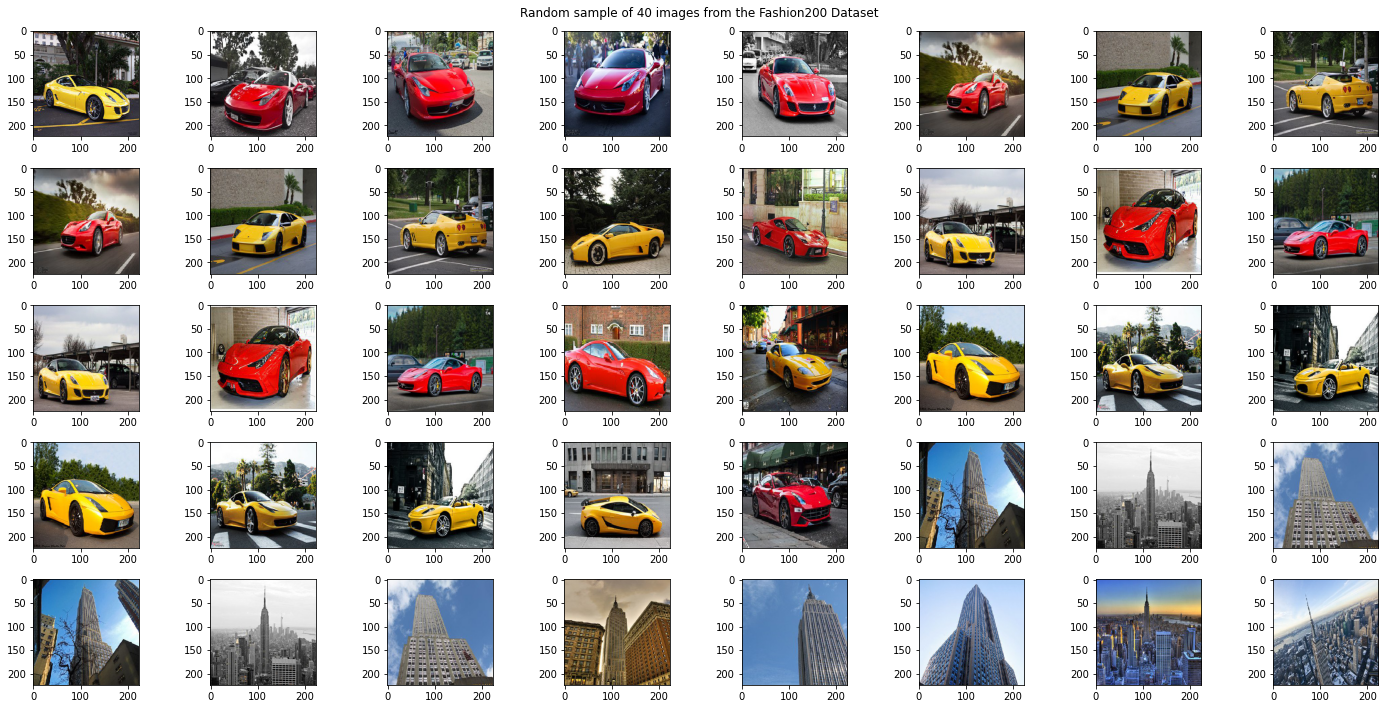

In [48]:
from random import shuffle
def plot_dataset(image_list): 
  shuffle(image_list.copy())
  num_cols = 8
  num_rows = 5
  # fig = plt.figure()
  f,ax = plt.subplots(num_rows,num_cols, figsize=(20,10)) 
  for i in range(num_rows):
    for j in range(num_cols):
        ax[i][j].imshow(image_list[i*num_rows + j]/255) 
  f.suptitle("Random sample of %s images from the Fashion200 Dataset" % (num_rows*num_cols))
  f.tight_layout()
  plt.show()

plot_dataset(img_holder)

## Extract Features and Build Index

- Get list of files in directory
- Convert to array of images
- Extract features using EfficientNetB0
- Build an index on extracted representations with FAISS
- Perform search on index


In [45]:
features = get_features(model_block7a, np.asarray(img_holder))
features = features.reshape(features.shape[0], -1)

In [46]:
feature_dim = features.shape[1]
faiss_index = faiss.IndexFlatL2(feature_dim)
faiss_index.add(features)   

## Peform Search 

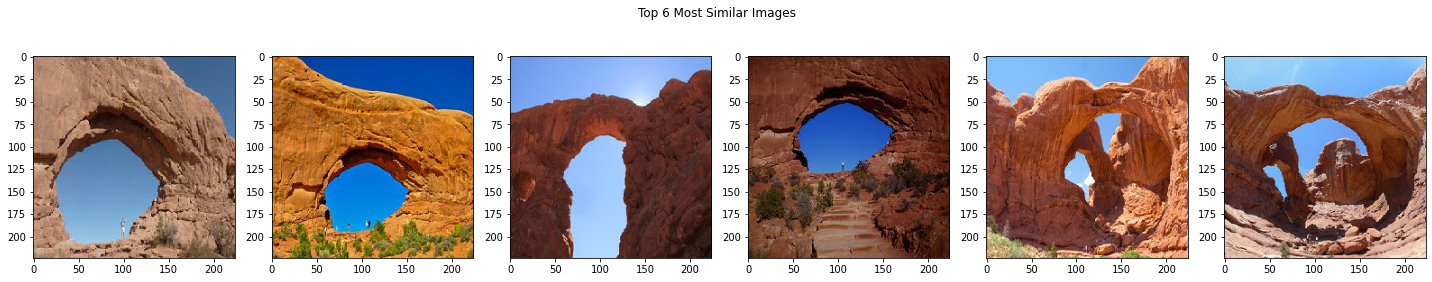

In [49]:
# There are 200 images in the dataset
# select  image i (using its index) and show the top k images that are most similar
i = 140
k = 6
query = features[i:i+1]
distances, indices = get_similar(faiss_index, query,k) 
query = img_holder[i]
plot_similar(query, [img_holder[i] for i in indices.tolist()[0]])